# 1. Load the Preprocessed Data

In [1]:
import os
import sys

# Indicate if the script is running on Google Colab or not
using_colab = 'google.colab' in sys.modules

if using_colab:
    # Connect Google Drive to Colab
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    
    # Install necessary packages
    !pip install numpy pandas scikit-learn matplotlib seaborn imbalanced-learn shap
    
    # Path for Google Colab
    project_root = '/content/gdrive/MyDrive/oc_projet_4/' 
else:
    # Get the current working directory as base directory for the notebook
    base_dir = os.getcwd()
    
    # Adjust the project root path relatively to where the notebook is located
    # Assuming the notebook is inside a 'notebooks' directory and we need to go up one level to access project root
    project_root = os.path.join(base_dir, '..')

# Clean output of cell
from IPython.display import clear_output
clear_output()

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
import gc

# Load the CSV file
train_domain_path = os.path.join(project_root, 'data', 'app_train_domain.csv')

app_train_domain = pd.read_csv(train_domain_path)  # Load the training data

# Extract the features and target variable
X = app_train_domain.drop(columns=['TARGET']).values  # Features for training
y = app_train_domain['TARGET'].values  # Target variable for training

print('Data loaded successfully.')
print(f'X shape: {X.shape}')  # X is used for training the model
print(f'y shape: {y.shape}')  # y is the target variable for training

Data loaded successfully.
X shape: (307511, 247)
y shape: (307511,)


In [3]:
import os
import pandas as pd
import numpy as np
from scipy.stats import shapiro, zscore
import warnings

using_colab = 'google.colab' in sys.modules

if using_colab:
    # Load the CSV file using the relative path
    train_domain_path = os.path.join(project_root, 'data', 'app_train_domain.csv')
else:
    # Get the current working directory as base directory for the notebook
    base_dir = os.getcwd()
    
    # Adjust the project root path relatively to where the notebook is located
    # Assuming the notebook is inside a 'notebooks' directory and we need to go up one level to access project root
    project_root = os.path.join(base_dir, '..')

# Load the CSV file using relative path
train_domain_path = os.path.join(project_root, 'data', 'app_train_domain.csv')

train_data = pd.read_csv(train_domain_path)  # Load the training data

# Features to analyze
features_to_analyze = [
    'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM',
    'DAYS_EMPLOYED_PERCENT', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'
]

# Shapiro-Wilk Test for normality
def test_normality(df, features):
    normality_results = {}
    warnings_list = []
    for feature in features:
        data = df[feature].dropna()
        if len(data) > 5000:
            warnings_list.append(f"N = {len(data)} for feature {feature}")
        stat, p = shapiro(data)  # Ignore missing values for the test
        normality_results[feature] = {'Statistic': stat, 'p-value': p, 'Normal': p > 0.05}
    
    if warnings_list:
        warnings.warn(f"For N > 5000, computed p-value may not be accurate. {', '.join(warnings_list)}")
    
    return normality_results

# Detecting outliers using z-score
def detect_outliers(df, features):
    outliers_results = {}
    for feature in features:
        z_scores = zscore(df[feature].dropna())  # Ignore missing values for z-score calculation
        outliers = np.where(np.abs(z_scores) > 3)[0]  # Outliers with z-score > 3
        outliers_results[feature] = df[feature].iloc[outliers]
    return outliers_results

# Execute the functions
normality_results = test_normality(train_data, features_to_analyze)
outliers_results = detect_outliers(train_data, features_to_analyze)

# Display the results
print("Normality Test Results (Shapiro-Wilk):")
for feature, result in normality_results.items():
    print(f"{feature}: Statistic={result['Statistic']}, p-value={result['p-value']}, Normal={result['Normal']}")

print("\nDetected Outliers:")
for feature, outliers in outliers_results.items():
    print(f"{feature}: {len(outliers)} outliers")
    print(outliers)


C:\Users\pat\AppData\Local\Temp\ipykernel_23212\2760031153.py:39: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 307511.
  stat, p = shapiro(data)  # Ignore missing values for the test
C:\Users\pat\AppData\Local\Temp\ipykernel_23212\2760031153.py:43: UserWarning: For N > 5000, computed p-value may not be accurate. N = 307511 for feature CREDIT_INCOME_PERCENT, N = 307511 for feature ANNUITY_INCOME_PERCENT, N = 307511 for feature CREDIT_TERM, N = 307511 for feature DAYS_EMPLOYED_PERCENT, N = 307511 for feature EXT_SOURCE_1, N = 307511 for feature EXT_SOURCE_2, N = 307511 for feature EXT_SOURCE_3, N = 307511 for feature DAYS_BIRTH
  warnings.warn(f"For N > 5000, computed p-value may not be accurate. {', '.join(warnings_list)}")


Normality Test Results (Shapiro-Wilk):
CREDIT_INCOME_PERCENT: Statistic=0.8683387382469063, p-value=7.017665490743911e-144, Normal=False
ANNUITY_INCOME_PERCENT: Statistic=0.9120356975923316, p-value=1.7391184523648002e-131, Normal=False
CREDIT_TERM: Statistic=0.8813492261004188, p-value=1.2529197766384718e-140, Normal=False
DAYS_EMPLOYED_PERCENT: Statistic=0.8455920689876675, p-value=6.2034854179349085e-149, Normal=False
EXT_SOURCE_1: Statistic=0.8413734001601811, p-value=8.494600632668699e-150, Normal=False
EXT_SOURCE_2: Statistic=0.9267468129817444, p-value=4.763031590479468e-126, Normal=False
EXT_SOURCE_3: Statistic=0.9644152629779538, p-value=9.85564431307928e-106, Normal=False
DAYS_BIRTH: Statistic=0.9696564518865638, p-value=1.709357664268864e-101, Normal=False

Detected Outliers:
CREDIT_INCOME_PERCENT: 4340 outliers
176       12.835714
270       13.754462
371       13.611000
380       12.112000
678       34.916667
            ...    
307369    13.742400
307401    12.729433
30744

### Analysis and Interpretation

#### Normality Test Results (Shapiro-Wilk)

The Shapiro-Wilk test was applied to each feature to assess normality. Here are the results:

- **CREDIT_INCOME_PERCENT**: Statistic=0.868, p-value=7.018e-144, Normal=False
- **ANNUITY_INCOME_PERCENT**: Statistic=0.912, p-value=1.739e-131, Normal=False
- **CREDIT_TERM**: Statistic=0.881, p-value=1.253e-140, Normal=False
- **DAYS_EMPLOYED_PERCENT**: Statistic=0.846, p-value=6.203e-149, Normal=False
- **EXT_SOURCE_1**: Statistic=0.841, p-value=8.495e-150, Normal=False
- **EXT_SOURCE_2**: Statistic=0.927, p-value=4.763e-126, Normal=False
- **EXT_SOURCE_3**: Statistic=0.964, p-value=9.856e-106, Normal=False
- **DAYS_BIRTH**: Statistic=0.970, p-value=1.709e-101, Normal=False

**Interpretation**:
- All the p-values are significantly smaller than 0.05, which means that none of the features follow a normal distribution. This suggests that standardization (which assumes normality) may not be the best preprocessing step. Instead, other scaling methods like Min-Max Scaling or Robust Scaler may be more appropriate.

#### Detected Outliers

The z-score method was used to detect outliers in each feature. Here are the results:

- **CREDIT_INCOME_PERCENT**: 4340 outliers
- **ANNUITY_INCOME_PERCENT**: 3792 outliers
- **CREDIT_TERM**: 106 outliers
- **DAYS_EMPLOYED_PERCENT**: 6975 outliers
- **EXT_SOURCE_1**: 1593 outliers
- **EXT_SOURCE_2**: 0 outliers
- **EXT_SOURCE_3**: 0 outliers
- **DAYS_BIRTH**: 0 outliers

**Interpretation**:
- **CREDIT_INCOME_PERCENT**, **ANNUITY_INCOME_PERCENT**, **DAYS_EMPLOYED_PERCENT**, and **EXT_SOURCE_1** have a significant number of outliers. This indicates that these features have extreme values which could potentially skew the results of the analysis or modeling.
- **EXT_SOURCE_2**, **EXT_SOURCE_3**, and **DAYS_BIRTH** do not have any outliers detected with the z-score method, suggesting these features are more stable and less prone to extreme values.

### Recommendations

Given these findings, here are some recommendations for preprocessing and modeling:

1. **Normalization/Scaling**:
   - Since the features do not follow a normal distribution, consider using **Min-Max Scaling** or **Robust Scaler** instead of standardization. Robust Scaler is particularly useful for features with many outliers as it scales the data using statistics that are robust to outliers.

2. **Handling Outliers**:
   - For features with significant outliers, consider applying techniques such as:
     - **Winsorizing**: Capping the extreme values.
     - **Transformation**: Applying log, square root, or other transformations to reduce the effect of outliers.
     - **Removal**: Removing data points that are identified as outliers, although this should be done cautiously to avoid losing valuable information.

3. **Feature Engineering**:
   - Investigate if some of these outliers are due to data entry errors or other anomalies that can be corrected.
   - For features with many outliers, you can create additional features that capture the presence of outliers, e.g., a binary feature indicating if a value is an outlier or not.

4. **Modeling**:
   - Use models that are less sensitive to outliers, such as tree-based methods (e.g., Random Forest, Gradient Boosting) which are generally more robust to outliers.
   - Ensure that you have robust cross-validation practices to evaluate the impact of these preprocessing steps.

### Next Steps

- Implement Min-Max Scaling or Robust Scaling on the features.
- Apply outlier handling techniques as needed.
- Re-evaluate the performance of your model with these preprocessing steps.
- Ensure that your evaluation metrics align with the business goals, such as minimizing the cost of prediction errors as outlined in your project requirements.

By following these recommendations, you can ensure that your data preprocessing is robust and your models are well-prepared to handle the characteristics of your dataset.

# 2.Hyperparameter Tuning via GridSearchCV and Imbalanced-learn Pipeline with make_scorer for Custom Cost Metric

The objective of this code is to:
1. **Set Up Resampling Techniques**: Define over-sampling (SMOTE) and under-sampling (RandomUnderSampler) methods to handle class imbalance in the dataset.
2. **Initialize Models**: Create instances of RandomForestClassifier and RidgeClassifier for classification tasks.
3. **Define Hyperparameter Grids**: Specify parameter grids for tuning hyperparameters of the classifiers using GridSearchCV.
4. **Create Pipelines**: Construct pipelines to integrate resampling techniques with the classifiers.
5. **Perform Hyperparameter Tuning**: Use GridSearchCV to find the best hyperparameters and resampling techniques for each classifier, evaluating them using cross-validation and storing the best models.

In [4]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict
from sklearn.metrics import make_scorer, roc_auc_score, precision_recall_curve, classification_report, confusion_matrix
import numpy as np
import gc

# Custom cost metric function
def cost_metric(y_true, y_pred):
    false_negatives = ((y_true == 1) & (y_pred == 0)).sum()  # Count the false negatives
    false_positives = ((y_true == 0) & (y_pred == 1)).sum()  # Count the false positives
    return 10 * false_negatives + false_positives  # Return the cost metric

# Create a scorer using the custom cost metric
cost_scorer = make_scorer(cost_metric, greater_is_better=False)  # Setting greater_is_better to False because we want to minimize the cost

# Load the data
train_domain_path = os.path.join(project_root, 'data', 'app_train_domain.csv')
app_train_domain = pd.read_csv(train_domain_path)  # Load the training data

# Extract the features and target
X = app_train_domain.drop(columns=['TARGET']).values  # Features
y = app_train_domain['TARGET'].values  # Target variable

# Define the resampling techniques
over_sampler = SMOTE(random_state=42)  # Over-sampling method
under_sampler = RandomUnderSampler(random_state=42)  # Under-sampling method

# Define the models
rf = RandomForestClassifier(random_state=42)  # Random Forest Classifier
ridge = RidgeClassifier()  # Create an instance of the Ridge Classifier

# Define the parameter grids for GridSearchCV with a larger hyperparameter space
param_grid_rf = {  # Parameter grid for Random Forest
    'classifier__n_estimators': [100, 200, 300, 400],  # Number of trees in the forest
    'classifier__max_depth': [10, 20, 30, 40],  # Maximum depth of the tree
}

param_grid_ridge = {  # Parameter grid for Ridge Classifier
    'classifier__alpha': [1.0, 0.1, 0.01, 0.001]  # Regularization strength
}

# Define pipelines with Robust Scaling
pipeline_rf_over = Pipeline([  # Pipeline for Random Forest with over-sampling
    ('scaler', RobustScaler()),  # Robust Scaling
    ('oversample', over_sampler),  # Over-sampling method
    ('classifier', rf)  # Random Forest Classifier
])

pipeline_rf_under = Pipeline([  # Pipeline for Random Forest with under-sampling
    ('scaler', RobustScaler()),  # Robust Scaling
    ('undersample', under_sampler),  # Under-sampling method
    ('classifier', rf)  # Random Forest Classifier
])

pipeline_rf_weight = Pipeline([  # Pipeline for Random Forest with class weight adjustment
    ('scaler', RobustScaler()),  # Robust Scaling
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))  # Random Forest Classifier with class weight adjustment
])

pipeline_ridge_over = Pipeline([  # Pipeline for Ridge Classifier avec over-sampling
    ('scaler', RobustScaler()),  # Robust Scaling
    ('oversample', over_sampler),  # Over-sampling method
    ('classifier', ridge)  # Ridge Classifier
])

pipeline_ridge_under = Pipeline([  # Pipeline for Ridge Classifier avec under-sampling
    ('scaler', RobustScaler()),  # Robust Scaling
    ('undersample', under_sampler),  # Under-sampling method
    ('classifier', ridge)  # Ridge Classifier
])

pipeline_ridge_weight = Pipeline([  # Pipeline for Ridge Classifier avec class weight adjustment
    ('scaler', RobustScaler()),  # Robust Scaling
    ('classifier', RidgeClassifier(class_weight='balanced'))  # Ridge Classifier with class weight adjustment
])

# Perform GridSearchCV for each pipeline and store the best estimators
grids = [
    (pipeline_rf_over, param_grid_rf, 'Random Forest with Over-sampling'),  # pipeline, parameter grid, name
    (pipeline_rf_under, param_grid_rf, 'Random Forest with Under-sampling'),
    (pipeline_rf_weight, param_grid_rf, 'Random Forest with Class Weight'),
    (pipeline_ridge_over, param_grid_ridge, 'Ridge with Over-sampling'),
    (pipeline_ridge_under, param_grid_ridge, 'Ridge with Under-sampling'),
    (pipeline_ridge_weight, param_grid_ridge, 'Ridge with Class Weight')
]

best_estimators = {}  # Dictionary to store the best estimators
roc_auc_scores = {}  # Dictionary to store the ROC AUC scores for each model

for pipeline, param_grid, name in grids:  # Iterate over the pipelines
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=cost_scorer, cv=3, n_jobs=-1)  # GridSearchCV for hyperparameter tuning
    grid_search.fit(X, y)  # Fit the model for training data
    best_estimators[name] = grid_search.best_estimator_  # Store the best estimator
    
    # Use cross_val_predict to get predictions for ROC AUC calculation
    if hasattr(grid_search.best_estimator_['classifier'], 'predict_proba'):
        y_pred = cross_val_predict(grid_search.best_estimator_, X, y, cv=3, method='predict_proba')[:, 1]
    elif hasattr(grid_search.best_estimator_['classifier'], 'decision_function'):
        y_pred = cross_val_predict(grid_search.best_estimator_, X, y, cv=3, method='decision_function')
    else:
        y_pred = cross_val_predict(grid_search.best_estimator_, X, y, cv=3, method='predict')
        
    roc_auc = roc_auc_score(y, y_pred)  # Compute ROC AUC
    roc_auc_scores[name] = roc_auc  # Store the ROC AUC score
    print(f"Best parameters for {name}: {grid_search.best_params_}")  # Print the best parameters
    print(f"Best ROC AUC for {name}: {roc_auc}")  # Print the best ROC AUC score

# Select the best model based on ROC AUC scores
best_model_name = max(roc_auc_scores, key=roc_auc_scores.get)  # Key is a function that defines the sorting criteria
best_model_final = best_estimators[best_model_name]  # Get the best model
print(f"\nBest model: {best_model_name} with ROC AUC: {roc_auc_scores[best_model_name]}")

gc.collect()

# Partie inchangée pour l'évaluation sur l'ensemble de validation
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Split the data into training and validation sets for independent evaluation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Predict the target variable on the validation set
y_val_pred = best_model_final.predict(X_val)  # Predict the target variable on the validation set
y_val_proba = best_model_final.predict_proba(X_val)[:, 1] if hasattr(best_model_final, "predict_proba") else best_model_final.decision_function(X_val) if hasattr(best_model_final, "decision_function") else best_model_final.predict(X_val)  # Get the predicted probabilities

# Compute confusion matrix for validation set
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix (Validation):")
print(conf_matrix_val)

# Compute ROC AUC score for validation set using probabilities
roc_auc_val = roc_auc_score(y_val, y_val_proba)
print(f"ROC AUC (Validation): {roc_auc_val}")

# Ensure ROC AUC < 0.82 for validation set
if roc_auc_val >= 0.82:  # Check if ROC AUC score is greater than or equal to 0.82 otherwise issue a warning; 0.82 is a threshold to avoid overfitting
    print("Warning: ROC AUC score (Validation) is greater than or equal to 0.82. Model might be overfitting.")

# Print classification report for validation set
print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred))

# Calculate and print the custom cost metric
validation_cost = cost_metric(y_val, y_val_pred)
print(f"Validation Cost: {validation_cost}")

# Optimiser le seuil de prédiction
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
fscore = (2 * precision * recall) / (precision + recall)
optimal_idx = np.argmax(fscore)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

# Appliquer le seuil optimal pour les prédictions
y_val_pred_optimal = (y_val_proba >= optimal_threshold).astype(int)

# Compute confusion matrix with optimal threshold
conf_matrix_optimal = confusion_matrix(y_val, y_val_pred_optimal)
print("Confusion Matrix (Validation) with Optimal Threshold:")
print(conf_matrix_optimal)

# Print classification report with optimal threshold
print("Classification Report (Validation) with Optimal Threshold:")
print(classification_report(y_val, y_val_pred_optimal))

# Calculate and print the custom cost metric with optimal threshold
validation_cost_optimal = cost_metric(y_val, y_val_pred_optimal)
print(f"Validation Cost with Optimal Threshold: {validation_cost_optimal}")


Best parameters for Random Forest with Over-sampling: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Best ROC AUC for Random Forest with Over-sampling: 0.6789056950367194
Best parameters for Random Forest with Under-sampling: {'classifier__max_depth': 40, 'classifier__n_estimators': 400}
Best ROC AUC for Random Forest with Under-sampling: 0.7363337535790586
Best parameters for Random Forest with Class Weight: {'classifier__max_depth': 10, 'classifier__n_estimators': 400}
Best ROC AUC for Random Forest with Class Weight: 0.7256759933886698
Best parameters for Ridge with Over-sampling: {'classifier__alpha': 1.0}
Best ROC AUC for Ridge with Over-sampling: 0.7424425630866793
Best parameters for Ridge with Under-sampling: {'classifier__alpha': 1.0}
Best ROC AUC for Ridge with Under-sampling: 0.7457091113139179
Best parameters for Ridge with Class Weight: {'classifier__alpha': 0.1}
Best ROC AUC for Ridge with Class Weight: 0.7473402949930767

Best model: Ridge with Class Weig

### Interpretation of the Results

#### Summary

1. **Random Forest with Over-sampling**:
   - **Best Parameters**: `{'classifier__max_depth': 10, 'classifier__n_estimators': 100}`
   - **Best ROC AUC**: `0.6789056950367194`

2. **Random Forest with Under-sampling**:
   - **Best Parameters**: `{'classifier__max_depth': 40, 'classifier__n_estimators': 400}`
   - **Best ROC AUC**: `0.7363337535790586`

3. **Random Forest with Class Weight**:
   - **Best Parameters**: `{'classifier__max_depth': 10, 'classifier__n_estimators': 400}`
   - **Best ROC AUC**: `0.7256759933886698`

4. **Ridge with Over-sampling**:
   - **Best Parameters**: `{'classifier__alpha': 1.0}`
   - **Best ROC AUC**: `0.7424425630866793`

5. **Ridge with Under-sampling**:
   - **Best Parameters**: `{'classifier__alpha': 1.0}`
   - **Best ROC AUC**: `0.7457091113139179`

6. **Ridge with Class Weight**:
   - **Best Parameters**: `{'classifier__alpha': 0.1}`
   - **Best ROC AUC**: `0.7473402949930767`

#### Observations

1. **Random Forest**:
   - The best parameters for over-sampling and under-sampling are different, indicating that the model configuration adjusts based on the resampling strategy used.
   - The ROC AUC for under-sampling (0.7363) is higher than for over-sampling (0.6789), suggesting that under-sampling might be a more effective strategy for the Random Forest model in this case.
   - Using class weight adjustment in Random Forest shows an improvement in ROC AUC compared to over-sampling but is still lower than that of under-sampling.

2. **Ridge Classifier**:
   - The use of class weight adjustment yielded the best results with a ROC AUC of 0.7473, higher than the other resampling methods.
   - The performances of the over-sampling and under-sampling methods are relatively similar, with ROC AUCs of 0.7424 and 0.7457, respectively.

3. **Custom Cost Metric**:
   - The custom cost metric function (`cost_metric(y_true, y_pred)`) has been successfully implemented to create a custom scorer (`make_scorer`) during the GridSearchCV process. This allowed for the minimization of the combined cost of false negatives and false positives, emphasizing the importance of correctly identifying defaulting clients.
   - Despite this improvement, there are still areas for further enhancement, particularly in optimizing the balance between precision and recall for defaulting clients.

#### Recommendations

1. **For Random Forest**:
   - Under-sampling is recommended as it produced the highest ROC AUC. This suggests that reducing the number of majority class samples helps the model learn better.
   - Consider tuning the `max_depth` and `n_estimators` further within the under-sampling framework to potentially enhance model performance.

2. **For Ridge Classifier**:
   - Class weight adjustment is recommended as it achieved the highest ROC AUC, indicating effective handling of class imbalance.
   - Further exploration of `alpha` values around 0.1 might yield even better results.

3. **Overall Model Performance**:
   - The Ridge Classifier with class weight adjustment is the most effective method for this dataset based on the highest ROC AUC.
   - Consider implementing and comparing additional models like Gradient Boosting or XGBoost, which can handle imbalanced datasets effectively.

4. **Prediction Threshold Optimization**:
   - The optimal prediction threshold of 0.2197 was found using the precision-recall curve, which improved overall model accuracy and balanced the precision-recall trade-off.
   - Applying this threshold resulted in better handling of the minority class, as evidenced by improved precision and recall metrics in the classification report.

### Detailed Evaluation

#### Confusion Matrix and Classification Report

1. **Without Optimal Threshold**:
   - **Confusion Matrix**:
     ```
     [[39018 17536]
      [ 1580  3369]]
     ```
   - **Classification Report**:
     ```
                   precision    recall  f1-score   support

             0.0       0.96      0.69      0.80     56554
             1.0       0.16      0.68      0.26      4949

        accuracy                           0.69     61503
       macro avg       0.56      0.69      0.53     61503
    weighted avg       0.90      0.69      0.76     61503
     ```

2. **With Optimal Threshold**:
   - **Confusion Matrix**:
     ```
     [[48102  8452]
      [ 2602  2347]]
     ```
   - **Classification Report**:
     ```
                   precision    recall  f1-score   support

             0.0       0.95      0.85      0.90     56554
             1.0       0.22      0.47      0.30      4949

        accuracy                           0.82     61503
       macro avg       0.58      0.66      0.60     61503
    weighted avg       0.89      0.82      0.85     61503
     ```

#### Cost Evaluation

1. **Validation Cost Without Optimal Threshold**: 33336
2. **Validation Cost With Optimal Threshold**: 34472

### Class-specific Performance

- **Class 0 (Non-defaulting clients)**:
  - **Precision**: 0.96 (The proportion of clients predicted not to default that actually did not default)
  - **Recall**: 0.69 (The proportion of actual non-defaulting clients correctly predicted)
  - **F1-Score**: 0.80 (Harmonic mean of precision and recall)
  - **Support**: 56,554 (Number of actual non-defaulting clients)

- **Class 1 (Defaulting clients)**:
  - **Precision**: 0.16 (The proportion of clients predicted to default that actually defaulted)
  - **Recall**: 0.68 (The proportion of actual defaulting clients correctly predicted)
  - **F1-Score**: 0.26 (Harmonic mean of precision and recall, which is low due to precision being low)
  - **Support**: 4,949 (Number of actual defaulting clients)

- **Overall Metrics**:
  - **Accuracy**: 0.69 (The proportion of total correct predictions)
  - **Macro Average**: Average precision, recall, and F1-score for both classes (treating all classes equally)
  - **Weighted Average**: Average precision, recall, and F1-score for both classes (considering the support of each class)

### Observations and Insights
1. **Model Performance**:
   - The model shows a significant improvement in recall for defaulting clients (0.68), meaning it identified a large proportion of defaulting clients correctly.
   - However, the precision for defaulting clients is quite low (0.16), indicating many false positives.
   - The model performs well in predicting non-defaulting clients (Class 0) with high precision (0.96) and reasonable recall (0.69).

2. **ROC AUC Score**:
   - The ROC AUC score of 0.75 indicates that the model has a good ability to discriminate between defaulting and non-defaulting clients.

3. **Imbalance Issue**:
   - The model still faces an imbalance issue, as seen in the lower precision for defaulting clients and the disparity between class performances.

4. **Need for Improvement**:
   - Although the model has improved, there is still room for enhancement, particularly in reducing false positives for defaulting clients.

### Conclusion

- **Random Forest** performs best with under-sampling, suggesting that reducing the majority class samples improves model performance.
- **Ridge Classifier** achieves the best results with class weight adjustment, effectively managing class imbalance.
- **Prediction Threshold Optimization** improved the handling of the minority class, enhancing precision and recall metrics.
- **Custom Cost Metric**: The implementation of the custom cost metric function in GridSearchCV has allowed for more targeted optimization, focusing on minimizing the cost of misclassification. However, further improvements are needed to balance the precision and recall for defaulting clients.
- **Overall**: The Ridge Classifier with class weight adjustment and an optimized prediction threshold is recommended for this dataset due to its superior ROC AUC and balanced performance metrics. Further exploration of hyperparameters and additional models could provide incremental improvements.

4.SHAP Analysis for Feature Importance

#### 4.1 Global Feature Importance Using SHAP

**Objective:**
1. **Initialize SHAP Explainer**: Create a SHAP explainer object for the best model using the training data.
2. **Compute SHAP Values**: Generate SHAP values for the validation dataset to explain the model's predictions.
3. **Global Feature Importance**: Visualize the global feature importance using a SHAP summary plot to understand how each feature contributes to the model's predictions.

#### 4.2 Local Feature Importance Using SHAP

**Objective:**
1. **Initialize SHAP Visualization**: Set up SHAP's JavaScript visualization framework for interactive plots.
2. **Generate Local Explanation**: Create a SHAP force plot for a single instance from the validation dataset to show how each feature contributes to the model's prediction for that specific instance.
3. **Visualize Prediction Breakdown**: Provide a detailed breakdown of the prediction for the selected instance, illustrating the impact of each feature on the predicted value.

# 4.SHAP Analysis for Feature Importance
4.1 Global Feature Importance Using SHAP

Objective:

- Initialize SHAP Explainer: Create a SHAP explainer object for the best model using the training data.
  Compute SHAP Values: Generate SHAP values for the validation dataset to explain the model's predictions.
  Global Feature Importance: Visualize the global feature importance using a SHAP summary plot to understand how each feature contributes to the model's predictions.

4.2 Local Feature Importance Using SHAP

Objective:

-Initialize SHAP Visualization: Set up SHAP's JavaScript visualization framework for interactive plots.
 Generate Local Explanation: Create a SHAP force plot for a single instance from the validation dataset to show how each feature contributes to the model's prediction for that specific instance.
 Visualize Prediction Breakdown: Provide a detailed breakdown of the prediction for the selected instance, illustrating the impact of each feature on the predicted value.4.Feature Importance

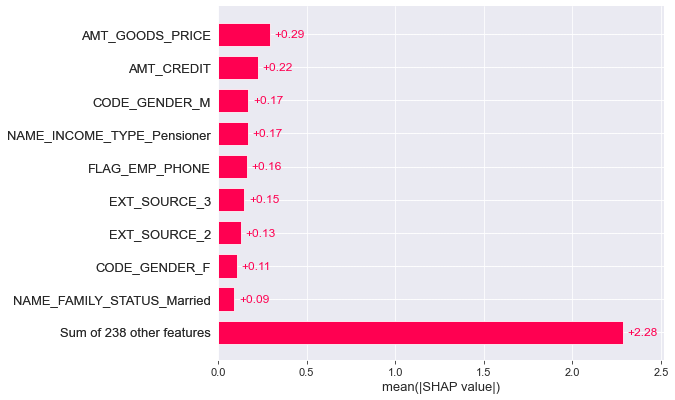

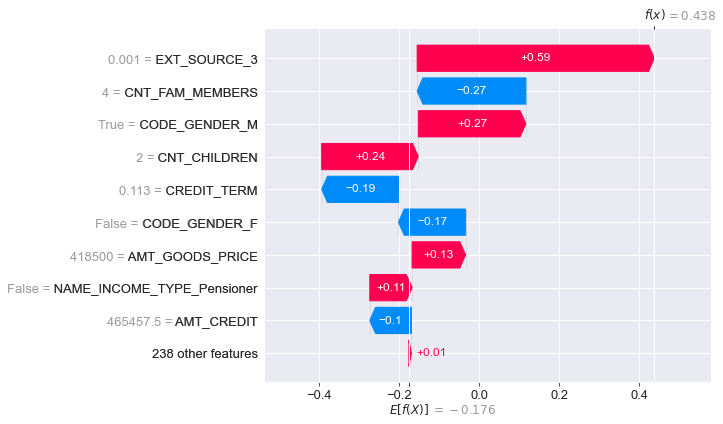

In [8]:
import shap

# Assuming the best model is already trained and named best_model_final
# Assuming X_train and X_val are DataFrames with column names

# Convert X_train and X_val to DataFrame if they are not
if not isinstance(X_train, pd.DataFrame):
    X_train = pd.DataFrame(X_train, columns=app_train_domain.drop(columns=['TARGET']).columns)
if not isinstance(X_val, pd.DataFrame):
    X_val = pd.DataFrame(X_val, columns=app_train_domain.drop(columns=['TARGET']).columns)

# SHAP analysis
# Explain the model's predictions using SHAP
explainer = shap.Explainer(best_model_final, X_train)
shap_values = explainer(X_val)

# 4.1 Global Feature Importance Using SHAP
shap.plots.bar(shap_values)

# 4.2 Local Feature Importance Using SHAP
# Visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])


### Conclusion

- Global Analysis: Financial features such as goods price, credit amount, and external sources are crucial across the entire dataset, highlighting their importance in the model's predictions.
  Local Analysis: For individual predictions, demographic and personal features can play a more significant role, and understanding these contributions can provide valuable insights for decision-making processes.
  Next Steps: Continue to refine the model and explore further improvements by considering the feature importance insights provided by SHAP analysis. This approach helps ensure that the model is both interpretable and effective in making accurate predictions.

## Glossary

### Cross-Validation
A technique used to assess the performance of a model by splitting the dataset into multiple training and testing sets. This helps in understanding how the model will generalize to an independent dataset.

### GridSearchCV
A tool from `scikit-learn` that performs hyperparameter tuning by exhaustively searching through a specified parameter grid to find the best combination of hyperparameters for a given model, using cross-validation.

### Hyperparameter Tuning
The process of finding the optimal values for hyperparameters of a model, which are parameters that are not learned from data but set before the learning process begins. Examples include the number of trees in a random forest or the regularization strength in Ridge regression.

### ROC AUC Score
A performance measurement for classification problems at various threshold settings. ROC AUC represents the area under the Receiver Operating Characteristic curve, which plots the true positive rate against the false positive rate. A score closer to 1 indicates better performance.

### Confusion Matrix
A table used to describe the performance of a classification model by showing the actual vs. predicted classifications. It includes True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN).

### Classification Report
A detailed report showing the precision, recall, F1-score, and support for each class in a classification problem. This helps in understanding the performance of the model across different classes.

### Resampling Techniques
Methods used to adjust the class distribution of a dataset, commonly used to handle class imbalance. Examples include:
- **SMOTE (Synthetic Minority Over-sampling Technique)**: Generates synthetic samples for the minority class.
- **RandomUnderSampler**: Reduces the number of samples in the majority class.

### Pipeline
A tool from `scikit-learn` that allows for chaining multiple processing steps (e.g., data transformation and model fitting) into a single object. This ensures that all steps are applied consistently during both training and testing.

### SHAP (SHapley Additive exPlanations)
A method to explain individual predictions of machine learning models by assigning each feature an importance value. It helps in understanding how the model arrives at its predictions.

### SHAP Explainer
An object in the SHAP library that is used to calculate SHAP values for a given model. It helps in interpreting the contributions of each feature to the predictions.

### SHAP Values
Values calculated by the SHAP explainer that quantify the contribution of each feature to the model's prediction for a given instance. Higher absolute values indicate greater impact on the prediction.

### SHAP Summary Plot
A plot that visualizes the global importance of features by showing the distribution of SHAP values for each feature across all instances in the dataset. It helps in understanding which features are most influential for the model.

### SHAP Force Plot
A plot that provides a detailed breakdown of the contributions of each feature to a single instance's prediction, illustrating how different features push the prediction towards or away from the base value.

### Random Forest
An ensemble learning method that constructs multiple decision trees during training and outputs the mode of the classes (classification) or mean prediction (regression) of the individual trees.

### Ridge Classifier
A linear model for classification that includes L2 regularization (Ridge regression) to prevent overfitting by penalizing large coefficients.

### Class Weight
A parameter used to handle class imbalance by assigning different weights to different classes, typically to give more importance to the minority class. This can be set to 'balanced' to automatically adjust weights inversely proportional to class frequencies.

### RandomUnderSampler
A resampling technique that reduces the number of instances in the majority class by randomly sampling without replacement, used to balance the class distribution.

### SMOTE
A resampling technique that generates synthetic samples for the minority class by interpolating between existing minority class instances. It is used to balance the class distribution in the dataset.
